In [1]:
import pandas as pd
import geopandas as gpd
#import seaborn as sbn
import sodapy
#import plotly.offline as plt
import matplotlib
import matplotlib.pyplot as plt
import json
import datetime

# Creem un dataframe amb el codi del municipi i el nombre d'habitants

In [2]:
pob = pd.read_csv("data/poblacio_per_municipis.csv", encoding='latin1', header=3, sep=";")
pob.columns

Index(['Any', 'Codi', 'Municipi', 'Edats', 'Homes', 'Dones', 'Total'], dtype='object')

In [3]:
total_pob = pob[pob['Edats']==' Total'].copy()
total_pob['Total'] = total_pob['Total'].str.replace(".","")
total_pob['Habitants'] = total_pob['Total'].astype(int)
total_pob['Codi'] = total_pob['Codi'].str[:-1]
total_pob['Codi'] = total_pob['Codi'].astype(int)
total_pob = total_pob[['Codi','Habitants']]
print(total_pob)

        Codi  Habitants
101    25001        179
203     8001      12489
305    25002        588
407    25003       5371
509     8002        288
...      ...        ...
96185  25255        470
96287  43177        428
96389  43178       2056
96491   8308        168
96593  43052       1170

[947 rows x 2 columns]


# Carreguem el mapa de Municipis

In [4]:
geodf = gpd.read_file('maps/Municipios.shp')
print(geodf.columns)
geodf['Codigo']=geodf['Codigo'].astype(int)
print(geodf['Codigo'])


Index(['Codigo', 'Texto', 'Cod_Prov', 'Provincia', 'Cod_CCAA', 'ComAutonom',
       'geometry'],
      dtype='object')
0       8001
1       8002
2       8003
3       8004
4       8005
       ...  
941    43902
942    43903
943    43904
944    43905
945    43906
Name: Codigo, Length: 946, dtype: int64


# i li afegim l'atribut del nombre d'habitants

In [5]:
geodf.drop(columns=['Habitants'], inplace=True, errors='ignore')
geodf = geodf.join(total_pob.set_index('Codi'), on='Codigo')

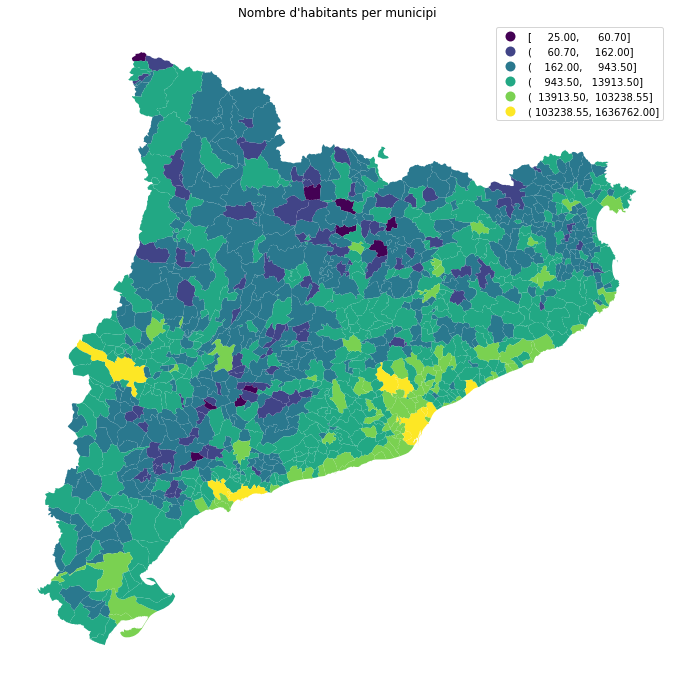

In [6]:
f, ax = plt.subplots(1, figsize=(12, 12))
geodf.plot(ax=ax, column='Habitants', legend=True, scheme="percentiles")
ax.set_axis_off()
ax.set_title("Nombre d'habitants per municipi")
pass

# Ara utilitzem sodapy per accedir a les dades obertes Covid publicades per la Generalitat

In [7]:
last_day = datetime.date.today() - datetime.timedelta(days=2)
#first_day = last_day - datetime.timedelta(days=21)
fourteen_ago = last_day - datetime.timedelta(days=13)
seven_ago = last_day - datetime.timedelta(days=6)
#print(first_day)

In [8]:
def load_covid(since):
    print("Loading Covid data since "+str(since)+" (inclusive)")
    with sodapy.Socrata("analisi.transparenciacatalunya.cat", None) as client:
        #count = 0
        data = []
        for item in client.get_all("jj6z-iyrp", where="data >= '"+str(since)+"'"):
            #count +=1
            data.append(item)
        #print(count)
    df_cases = pd.DataFrame(data)
    df_cases['data'] = pd.to_datetime(df_cases['data'])
    df_cases['numcasos'] = df_cases['numcasos'].astype(int)
    df_cases['municipicodi'] = df_cases['municipicodi'].astype(float)
    df_cases['municipicodi'] = df_cases['municipicodi'].fillna(0)
    df_cases['municipicodi'] = df_cases['municipicodi'].astype(int)
    return df_cases


In [9]:
df_cases = load_covid(since=fourteen_ago)
df_cases

Loading Covid data since 2020-08-26 (inclusive)


,data,comarcacodi,comarcadescripcio,municipicodi,municipidescripcio,sexecodi,sexedescripcio,resultatcoviddescripcio,numcasos
0,2020-08-26,21,Maresme,8219,Vilassar de Mar,1,Dona,Sospitós,12
1,2020-08-26,20,Gironès,17079,Girona,1,Dona,Sospitós,67
2,2020-08-26,13,Barcelonès,8101,L'Hospitalet de Llobregat,1,Dona,Sospitós,364
3,2020-08-26,40,Vallès Occidental,8260,Santa Perpétua de Mogoda,0,Home,Sospitós,13
4,2020-08-26,40,Vallès Occidental,8187,Sabadell,1,Dona,Sospitós,154
...,...,...,...,...,...,...,...,...,...
14583,2020-09-09,20,Gironès,17079,Girona,0,Home,Positiu per Test Ràpid,1
14584,2020-09-09,40,Vallès Occidental,8279,Terrassa,0,Home,Sospitós,2
14585,2020-09-09,38,Urgell,25217,Tàrrega,0,Home,Sospitós,1
14586,2020-09-09,30,Ribera d'Ebre,43060,Flix,1,Dona,Positiu PCR,1


In [10]:
print(df_cases['resultatcoviddescripcio'].unique())
#print(df_cases['municipicodi'].unique())


['Sospitós' 'Positiu per ELISA' 'Positiu PCR' 'Epidemiològic'
 'Positiu per Test Ràpid']


# Calculem el nombre de casos per municipi 

In [11]:
# Compute average cases in the period [start-end] with both days included.

def average_cases_period(data, start, end):
    cases_by_municipi = {}
    for _,entry in data.iterrows():
        if (entry['data'] >= start) and (entry['data'] <= end):
            #if ('municipicodi' in entry) and \
            if (entry['resultatcoviddescripcio']!='Sospitós') and\
                (entry['resultatcoviddescripcio']!='Positiu per Test Ràpid'): #and \
                #(type(entry['municipicodi'])==str):
                #print(entry['resultatcoviddescripcio'])
                #print(entry['municipicodi'])
                #print(entry['data'])
                if entry['municipicodi'] in cases_by_municipi:
                    cases_by_municipi[entry['municipicodi']] += entry['numcasos']
                else:
                    cases_by_municipi[entry['municipicodi']] = entry['numcasos']
    #print(cases_by_municipi)
    cases_df = pd.DataFrame(cases_by_municipi.items(), columns=["Codi","Cases"])
    cases_df['Codi'] = cases_df['Codi'].astype(int)
    cases_df['Cases'] = cases_df['Cases'].astype(float)
    #print("Days:"+str((end-start).days))
    cases_df['AverageCases'] = cases_df['Cases']/((end-start).days + 1)
    return cases_df


# i fem els plots

In [12]:
def make_plot_schools(geodf, df_cases, start, end):
    average_cases = average_cases_period(df_cases, start, end)
    mygeodf = geodf.copy()
    #drop(columns=["Cases",'AverageCases'], errors='ignore')
    mygeodf = mygeodf.join(average_cases.set_index('Codi'), on='Codigo')
    mygeodf['DailyIncidence'] = 100000*(mygeodf['AverageCases']/mygeodf['Habitants'])
    mygeodf['DailyIncidence'] = mygeodf['DailyIncidence'].fillna(0.0001)
    #geodf.plot(column='DailyIncidence', legend=True)
    mygeodf['DDailyIncidence'] = pd.cut(mygeodf['DailyIncidence'], bins=[0,1,10,25,1000])
    #geodf['DDailyIncidence'] = geodf['DDailyIncidence'].fillna(0)
    
    f, ax = plt.subplots(1, figsize=(12, 12))
    mygeodf.plot(ax=ax, column='DDailyIncidence', linewidth=0.5, edgecolor='0.5', legend=True, legend_kwds={'loc': 'lower right','title':"Casos diaris per 100,000 persones"}, cmap=matplotlib.colors.ListedColormap(["green","yellow","orange","red"]))
    ax.set_axis_off()
    ax.set_title("Municipis que haurien d'endarrerir l'obertura d'escoles (en vermell) basat en \n"
                 "la mitjana de casos diaria per 100.000 habitants en el període entre " + str(start) + " i " + str(end))

    plt.axis('equal')
    f.patch.set_facecolor('whitesmoke')
    plt.savefig("figs/Schools"+str(start)+"-"+str(end)+".png", transparent=False)
    plt.show() 
    return mygeodf
    


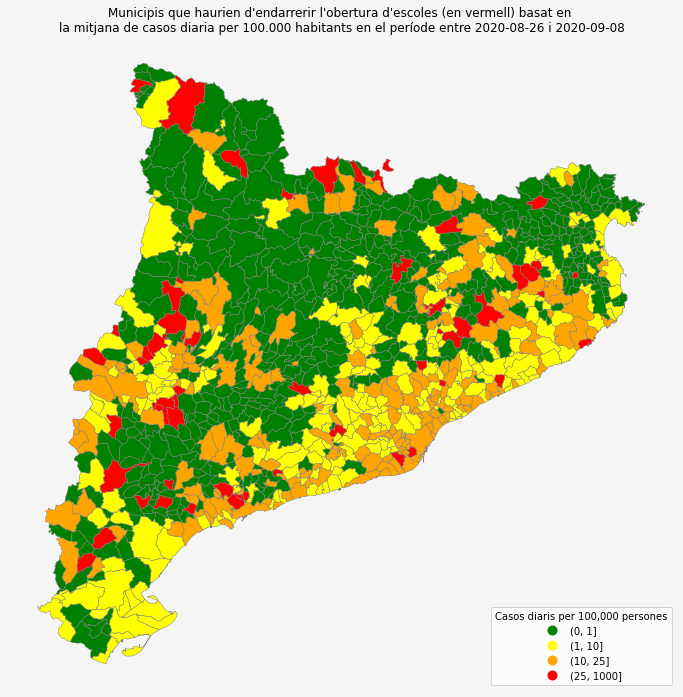

In [13]:
mgdf14 = make_plot_schools(geodf, df_cases, fourteen_ago, last_day)

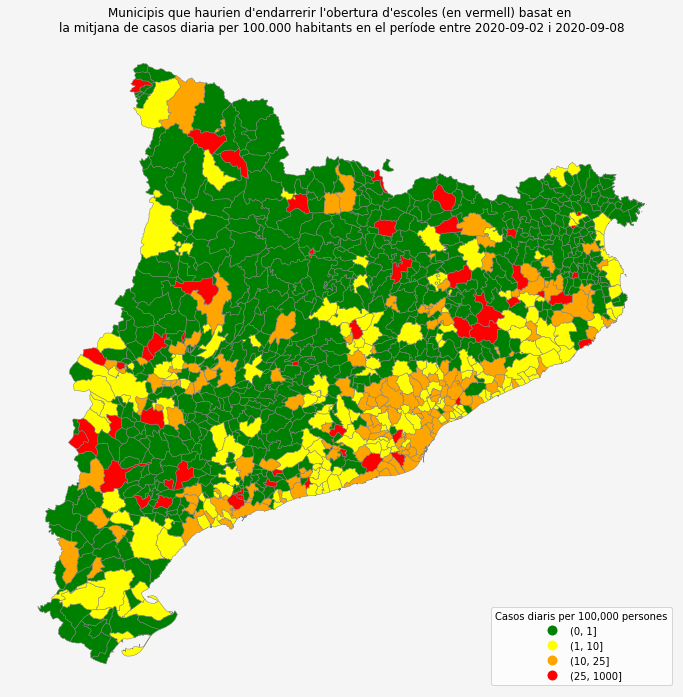

In [14]:
mgdf7 = make_plot_schools(geodf, df_cases, seven_ago, last_day)

In [15]:
mgdf14[mgdf14['Codigo']==8184]['DailyIncidence']

182    21.669052
Name: DailyIncidence, dtype: float64

In [16]:
mgdf7[mgdf7['Codigo']==40]['DailyIncidence']

Series([], Name: DailyIncidence, dtype: float64)

In [17]:
mgdf7[mgdf7['DailyIncidence']>25]['Texto']

19                         Begues
26                 Cabanyes (Les)
61            Castellnou de Bages
108                         Lluçà
122                 Molins de Rei
152                        Òrrius
165          Pobla de Lillet (La)
172                    Puigdàlber
197         Sant Boi de Llobregat
203       Sant Cugat Sesgarrigues
225        Sant Martí Sesgueioles
251          Santa Maria de Corcó
284                    Torrelavit
318                        Anglès
319                      Arbúcies
320                    Argelaguer
373                         Flaçà
440                     Puigcerdà
441                         Quart
454                          Salt
458         Sant Feliu de Guíxols
462            Sant Hilari Sacalm
465    Sant Joan de les Abadesses
470         Sant Martí de Llémena
479       Santa Llogaia d'Àlguema
511                   Vilabertran
516                      Viladrau
520             Vilallonga de Ter
536                   Alàs i Cerc
549           

In [22]:
mgdf7[(mgdf7['DailyIncidence']>25) & (mgdf7['Habitants']>2000)]['Texto'].sort_values()

549                    Almacelles
318                        Anglès
319                      Arbúcies
568                      Balaguer
19                         Begues
786                       Bellvei
809                     Constantí
817                        Falset
822                          Flix
122                 Molins de Rei
856                   Morell (El)
870         Pobla de Mafumet (La)
440                     Puigcerdà
441                         Quart
694                      Rosselló
454                          Salt
197         Sant Boi de Llobregat
458         Sant Feliu de Guíxols
462            Sant Hilari Sacalm
465    Sant Joan de les Abadesses
251          Santa Maria de Corcó
Name: Texto, dtype: object

In [19]:
mgdf14[(mgdf14['DailyIncidence']>25)&(mgdf14['Habitants']>2000)]['Texto']

40                       Canovelles
100    Hospitalet de Llobregat (L')
197           Sant Boi de Llobregat
207           Sant Feliu de Codines
295                             Vic
440                       Puigcerdà
454                            Salt
458           Sant Feliu de Guíxols
462              Sant Hilari Sacalm
465      Sant Joan de les Abadesses
544                        Alfarràs
549                      Almacelles
568                        Balaguer
585           Borges Blanques (Les)
633                          Juneda
705               Seu d'Urgell (La)
809                       Constantí
817                          Falset
822                            Flix
870           Pobla de Mafumet (La)
906             Selva del Camp (La)
Name: Texto, dtype: object